In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MultiFold, MLP, SetStyle, HistRoutine, net, PET
from of_transformer import block, embed, input_distributed, net_utils, of_transformer, pair_embed, sequence_trimmer 

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="2" #odslserv 0123 überprüfen
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="3"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-08-18 13:47:35.861405: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 13:47:35.876578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755517655.893198 2440276 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755517655.898534 2440276 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755517655.913207 2440276 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#real_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/data.Nominal.root'
#herwig_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/ttbar_enhanced_Herwig71_fast.Nominal.root'
#pythia_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/ttbar_enhanced.Nominal.root'
#
#real_file = uproot.open(real_data)
#real_tree = real_file['NOSYS/physics']
#
#
#herwig_file = uproot.open(herwig_data)
#herwig_tree = herwig_file['NOSYS']
#
#pythia_file = uproot.open(pythia_data)
#pythia_tree = pythia_file['NOSYS']


#real_array = real_tree.arrays()
#herwig_array = herwig_tree.arrays()
#pythia_array = pythia_tree.arrays()

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_nominal_matched.pkl')
#herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_nominal_matched.pkl')
data_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_data.pkl')
pythia_df["w2"] = pythia_df['eventWeight'].to_numpy()*pythia_df['eventWeight'].to_numpy()
#herwig_df["w2"] = herwig_df['eventWeight'].to_numpy()*herwig_df['eventWeight'].to_numpy()
pythia_df.fillna(0.0, inplace=True)
data_df.fillna(0.0, inplace=True)
#herwig_df.fillna(0.0, inplace=True)

In [3]:
def MC_data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

def DATA_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    
    return reco_features

In [4]:
pythia_reco, pythia_truth = MC_data_shaper(pythia_df)
#herwig_reco, herwig_truth = MC_data_shaper(herwig_df)
data_array = DATA_shaper(data_df)

pythia_weights = pythia_df['eventWeight'].to_numpy()
#herwig_weights = herwig_df['eventWeight'].to_numpy()
data_weights = data_df['eventWeight'].to_numpy()

In [5]:
all_indices_pythia = np.arange(len(pythia_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_pythia)

# First random sample
random_indices_pythia_1 = all_indices_pythia[:1_000_000]
# Second, independent (non-overlapping) sample
random_indices_pythia_2 = all_indices_pythia[1_000_000:2_000_000]

# First Pythia sample
pythia_reco_train    = pythia_reco[random_indices_pythia_1]
pythia_truth_train   = pythia_truth[random_indices_pythia_1]
pythia_weights_train = pythia_weights[random_indices_pythia_1]

# Second Pythia sample
pythia_reco_test    = pythia_reco[random_indices_pythia_2]
pythia_truth_test   = pythia_truth[random_indices_pythia_2]
pythia_weights_test = pythia_weights[random_indices_pythia_2]

# First Herwig sample
#random_indices_herwig = np.random.choice(len(herwig_reco), size=1_000_000, replace=False)
#herwig_reco_train   = herwig_reco[random_indices_herwig]
#herwig_truth_train   = herwig_truth[random_indices_herwig]
#herwig_weights_train = herwig_weights[random_indices_herwig]

In [6]:
#herwig_loader = DataLoader(reco = herwig_reco_train, gen = herwig_truth_train, weight = herwig_weights_train,
#                           normalize=True, normalization_factor = np.sum(herwig_weights_train))

pythia_loader = DataLoader(reco = pythia_reco_train, gen = pythia_truth_train, weight = pythia_weights_train,
                           normalize=True, normalization_factor = np.sum(pythia_weights_train))
data_loader = DataLoader(reco = data_array[:1_000_000], weight = data_weights[:1_000_000],
                         normalize=True, normalization_factor = np.sum(data_weights[:1_000_000]))

INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 67227.828125 ...
INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000.0 ...


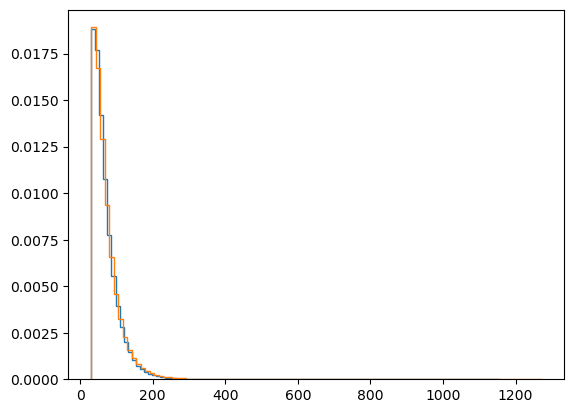

In [7]:
#plt.hist(herwig_loader.gen[:,0,0], weights=herwig_loader.weight, bins=100, histtype='step',density=True)
plt.hist(pythia_loader.gen[:,0,0], weights=pythia_loader.weight, bins=100, histtype='step',density=True)
plt.hist(data_loader.reco[:,0,0], weights=data_loader.weight, bins=100, histtype='step', density=True)
#plt.yscale('log')
plt.show()

(<Figure size 900x900 with 2 Axes>,
 <Axes: ylabel='Normalized number of events'>)

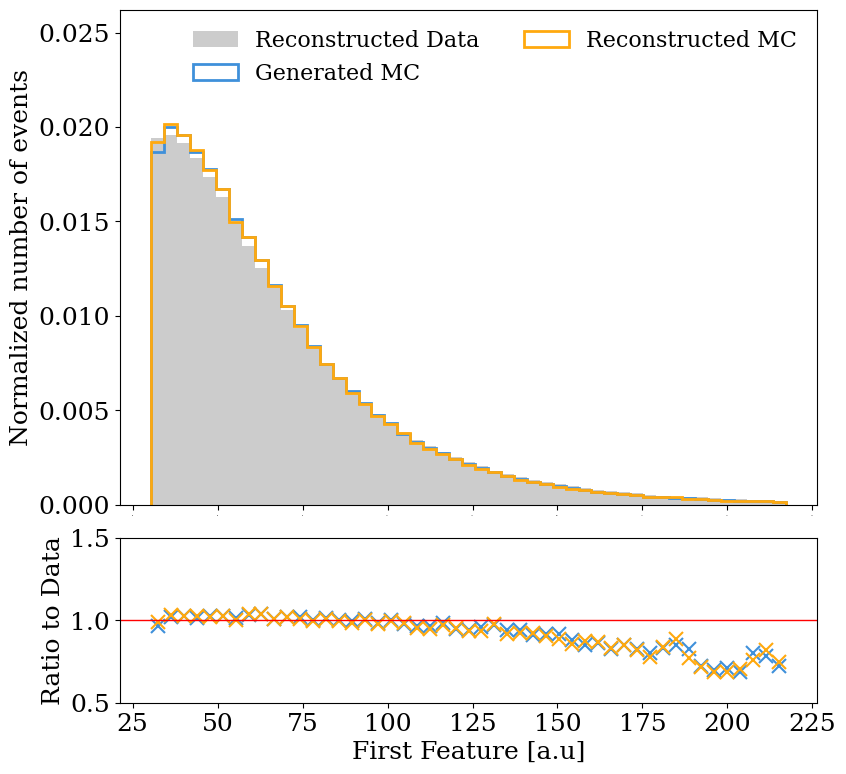

In [8]:
SetStyle()
data_dict = {
   # 'Truth Distribution': herwig_loader.gen[:,0,0],
    'Reconstructed Data': data_loader.reco[:,0,0],
    'Generated MC': pythia_loader.gen[:,0,0],
    'Reconstructed MC': pythia_loader.reco[:,0,0],
}
weight_dict = {
       # 'Truth Distribution': herwig_loader.weight,
        'Reconstructed Data': data_loader.weight,
        'Generated MC': pythia_loader.weight,
        'Reconstructed MC': pythia_loader.weight,
}
HistRoutine(data_dict,'First Feature [a.u]', reference_name = 'Reconstructed Data', weights=weight_dict,plot_ratio=True)

In [34]:
test_model = of_transformer.OfTransformer(
    input_dim=4,      # number of features per particle
    num_classes=2     # for binary classification (change if needed)
)
print(test_model)

OfTransformer(
  (embed): Embed(
    (embed): InputDistributed(
      (module): Sequential(
        (0): Linear(in_features=4, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=128, out_features=512, bias=True)
        (3): GELU(approximate='none')
        (4): Linear(in_features=512, out_features=128, bias=True)
        (5): GELU(approximate='none')
      )
    )
  )
  (pair_embed): PairEmbed(
    (embed_blocks): ModuleList(
      (0): Conv1dBlock(
        (block): Sequential(
          (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
      )
      (1-2): 2 x Conv1dBlock(
        (block): Sequential(
          (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class MaskedAveragePooling(layers.Layer):
    def call(self, x, mask):
        # x: (batch, seq_len, features)
        # mask: (batch, seq_len), dtype bool
        mask = tf.cast(mask, tf.float32)[..., tf.newaxis]  # (batch, seq_len, 1)
        x = x * mask
        return tf.reduce_sum(x, axis=1) / tf.reduce_sum(mask, axis=1)

class ParticleMaskLayer(layers.Layer):
    def call(self, x):
        return tf.reduce_any(tf.not_equal(x, 0), axis=-1)  # shape: (batch, seq)

def build_transformer_model(input_shape=(12, 4),
                            num_heads=4,
                            ff_dim=64,
                            num_transformer_blocks=2,
                            dropout_rate=0.1):

    inputs = Input(shape=input_shape)

    # Get attention mask: True where not padded
    mask = ParticleMaskLayer()(inputs)  # shape: (batch, 11)

    # Learned positional embedding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embed = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = inputs + pos_embed  # broadcasting position embedding

    for _ in range(num_transformer_blocks):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=input_shape[1]
        )(x, x, attention_mask=mask[:, tf.newaxis, :])  # shape: (batch, 1, 11)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ff_output = layers.Dense(ff_dim, activation='relu')(x)
        ff_output = layers.Dense(input_shape[1])(ff_output)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Use masked average pooling instead of GlobalAveragePooling1D
    x = MaskedAveragePooling()(x, mask)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

In [10]:
model1 = build_transformer_model()
model2 = build_transformer_model()

I0000 00:00:1755518042.976611 2440276 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 139770 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:43:00.0, compute capability: 9.0


In [11]:
omnifold = MultiFold(
    "WWbb_transformer",
    model1,
    model2,
    data_loader,
    pythia_loader,
    batch_size = 128,
    niter = 4,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'weights_transformer',
    verbose = True,
    lr = 5e-5,
)

15625 training steps at reco and 15625 steps at gen


In [15]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 2000000, Test events used: 399999
################################################################################
Epoch 1/100


I0000 00:00:1754549271.544395 1844293 service.cc:152] XLA service 0x56260c8f0ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754549271.544442 1844293 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-08-07 08:47:51.680323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754549272.453408 1844293 cuda_dnn.cc:529] Loaded cuDNN version 90501


   35/12500 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - loss: 0.2660 

I0000 00:00:1754549280.346735 1844293 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - loss: 0.2105 - val_loss: 0.2007 - learning_rate: 5.0000e-05
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 0.2008 - val_loss: 0.2007 - learning_rate: 5.0000e-05
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 0.2008 - val_loss: 0.2007 - learning_rate: 5.0000e-05
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 0.2008 - val_loss: 0.2007 - learning_rate: 5.0000e-05
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 0.2006 - val_loss: 0.2007 - learning_rate: 5.0000e-05
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.2007 - val_loss: 0.2007 - learning_rate: 5.0000e-05
Epoch 7/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.2006 - val_loss: 0.2007 - learning_rate: 5.0000e-05
Epoch 8/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - loss: 0.2008 - val_loss: 0.2007 - learning_rate: 5.0000e-05
Epoch 9/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms

In [16]:
unfolded_weights  = omnifold.reweight(pythia_truth_test,omnifold.model2,batch_size=1000)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 996us/step


In [17]:
#np.save("weights_transformer/unfolded_weights.npy", unfolded_weights)

In [12]:
unfolded_weights = np.load("weights_transformer/unfolded_weights.npy")

In [13]:
print(unfolded_weights.shape)

(1000000,)


In [14]:
sigma_MC_tot = np.sqrt(np.sum(pythia_df['w2'].to_numpy()))/np.sum(pythia_df['eventWeight'].to_numpy())
sigma_data_tot = 1/np.sqrt(np.sum(data_df['eventWeight'].to_numpy()))
total_SF = sigma_data_tot/sigma_MC_tot

print(sigma_data_tot, sigma_MC_tot, total_SF)
print(sigma_MC_tot/np.sqrt(np.sum(pythia_df['eventWeight'].to_numpy())))
print(1/np.sqrt(np.sum(pythia_df['w2'].to_numpy())))

0.0004821333 0.00021435761 2.2492008
1.2937434e-07
0.0016993374


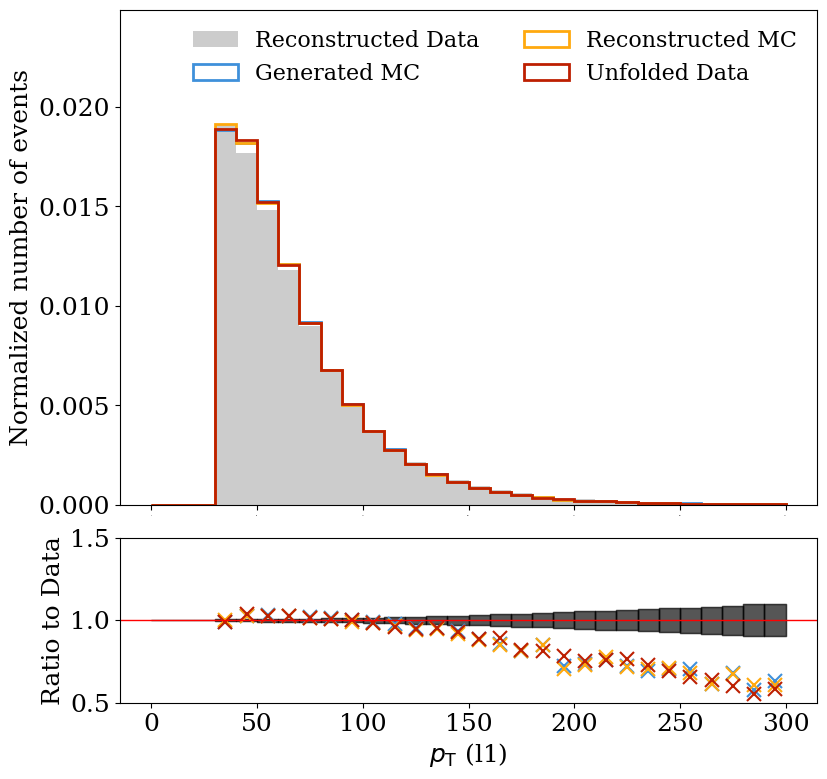

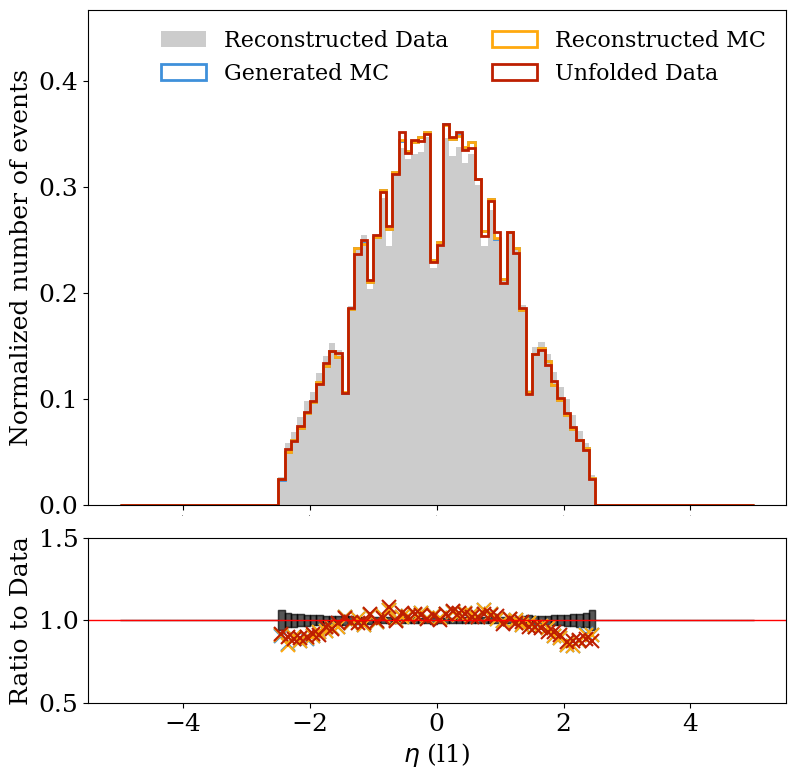

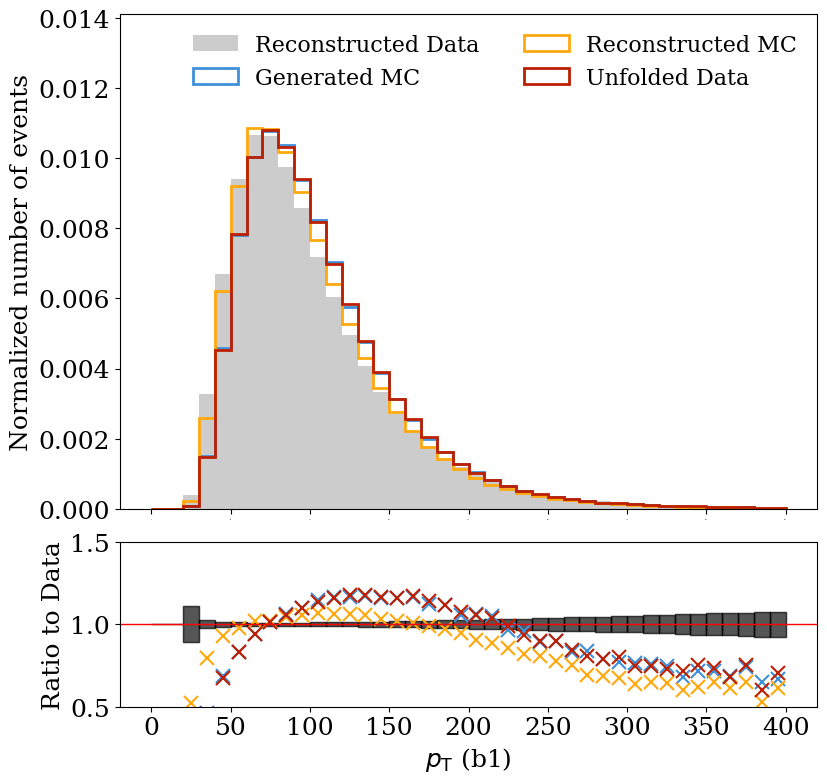

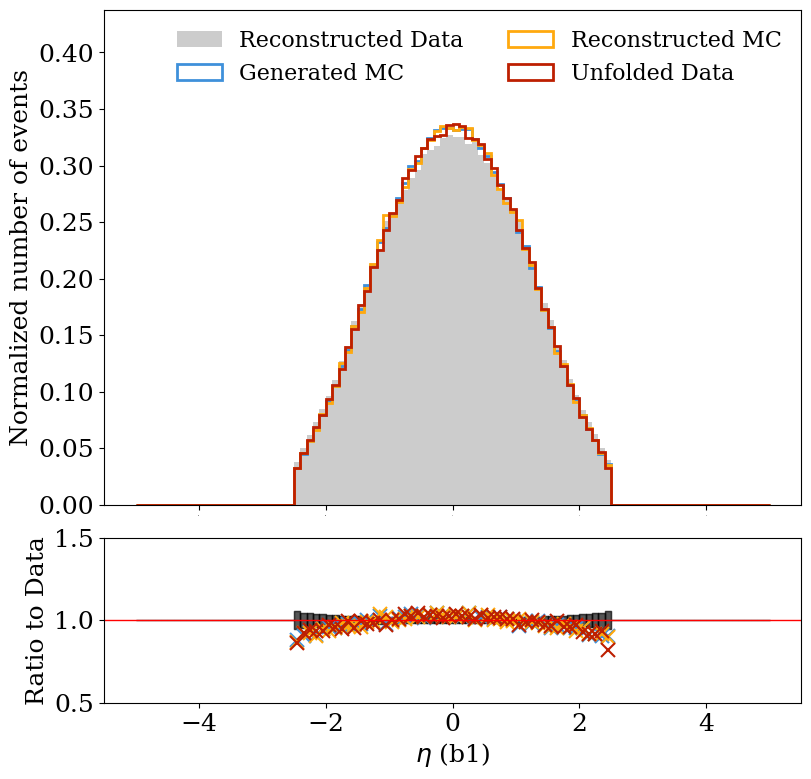

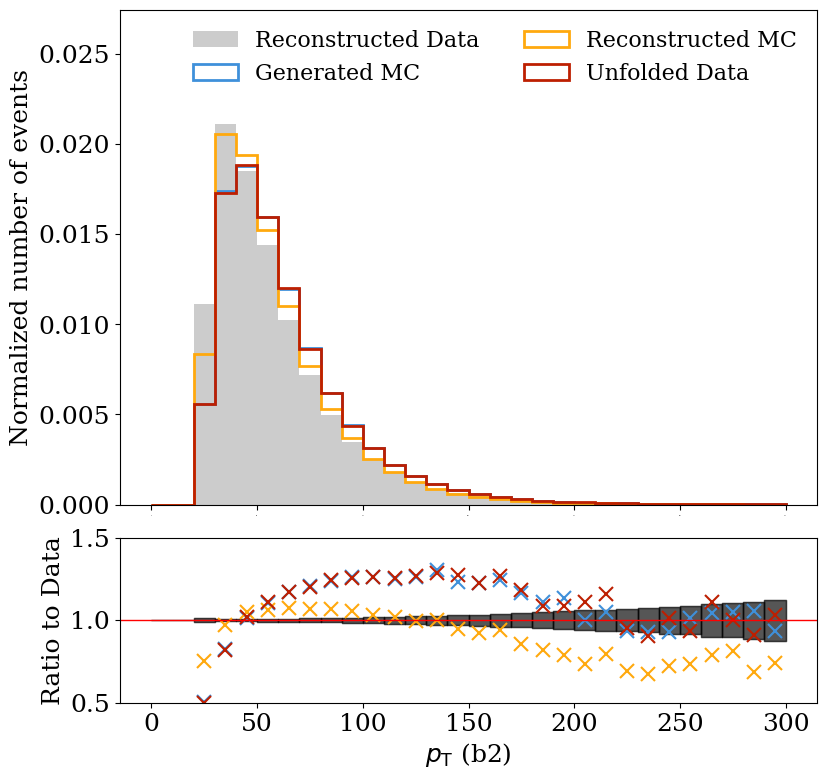

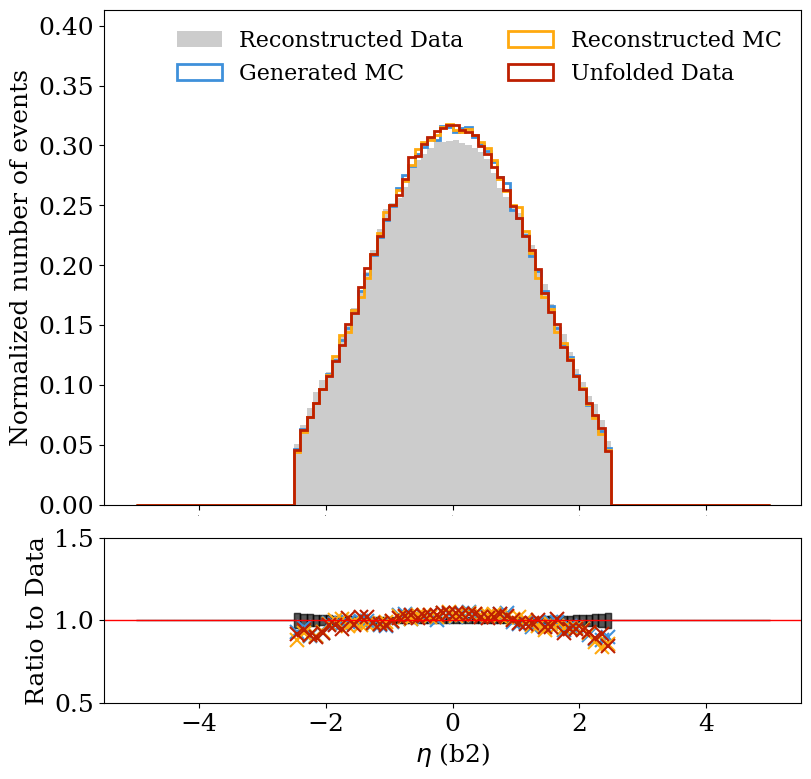

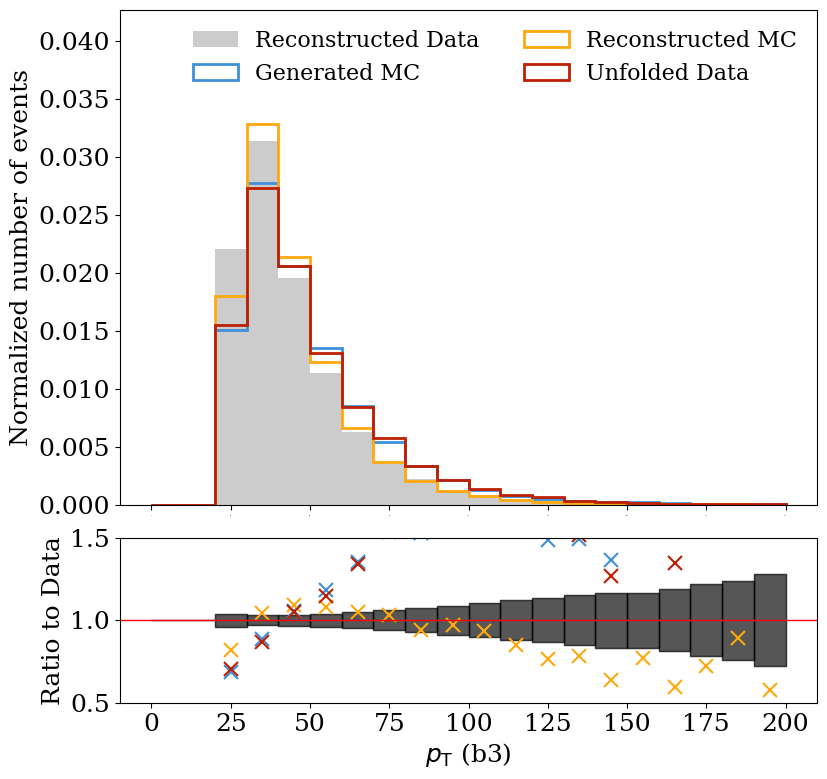

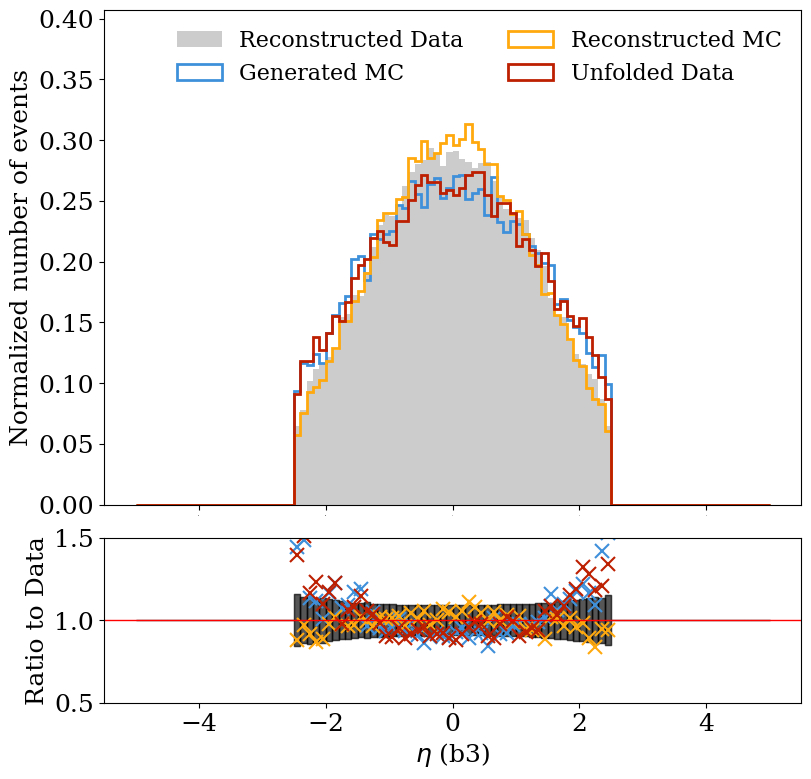

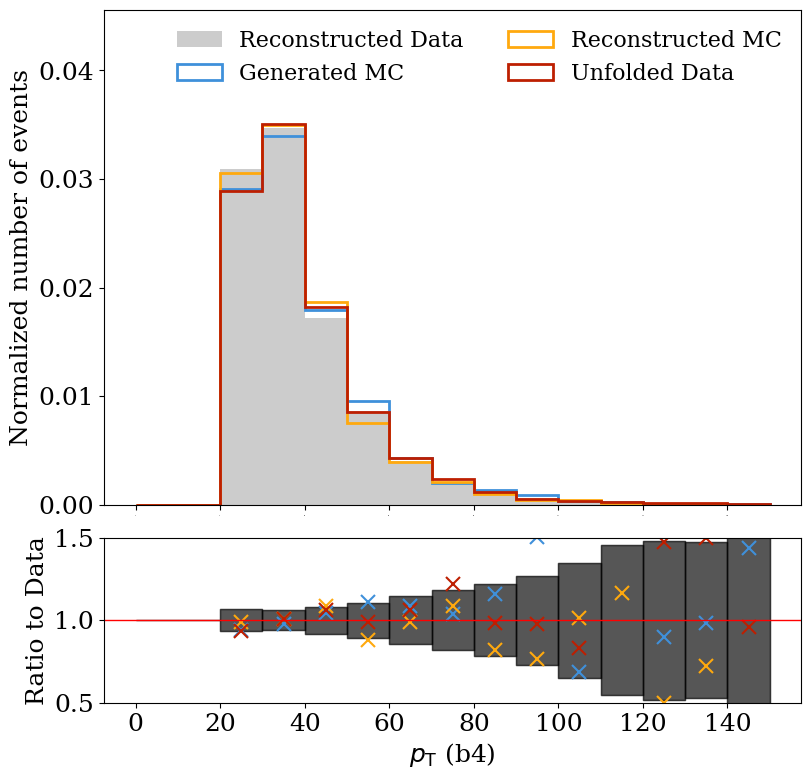

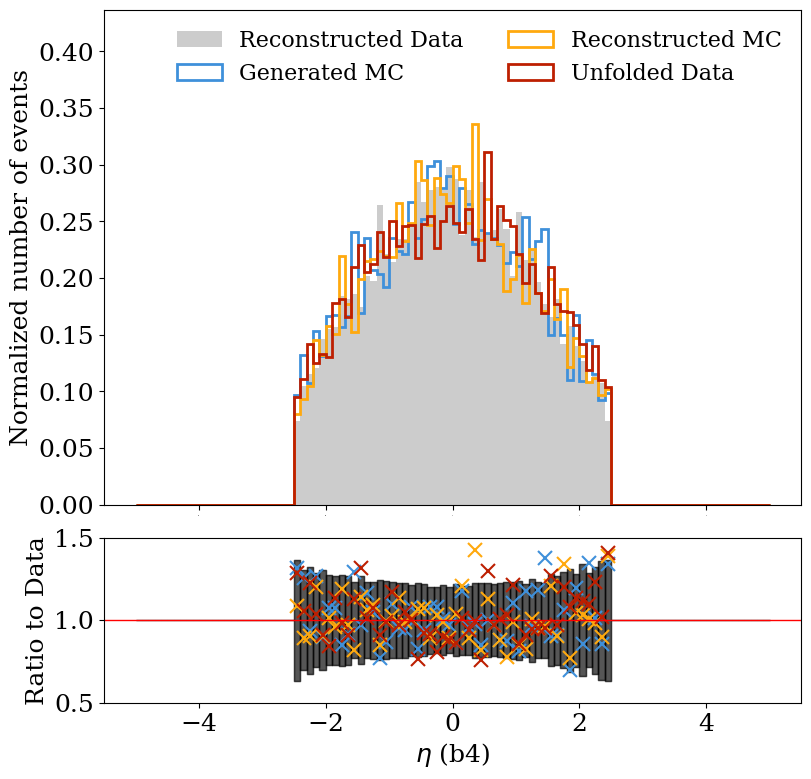

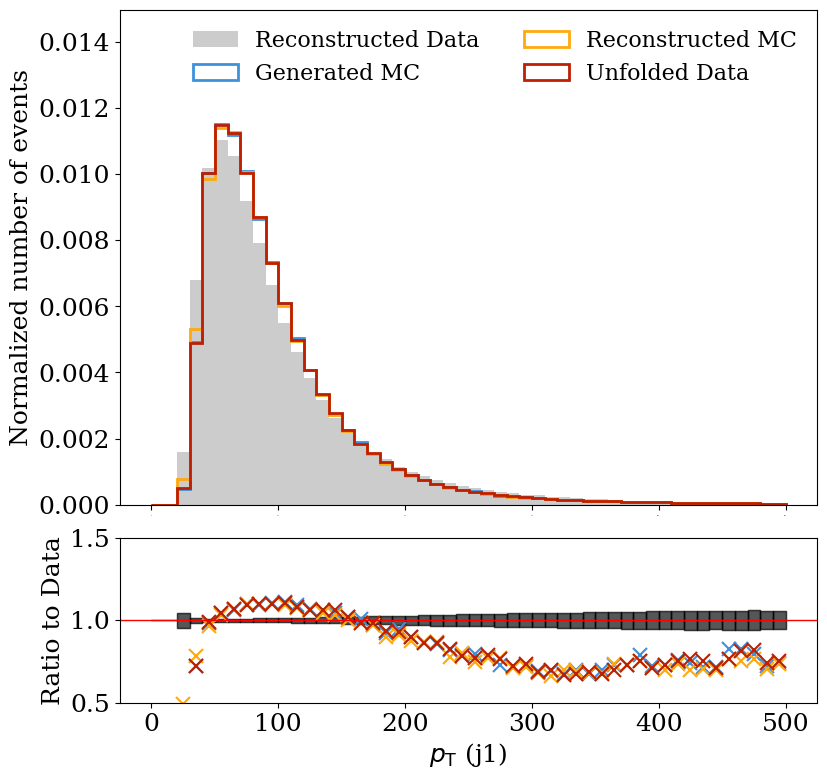

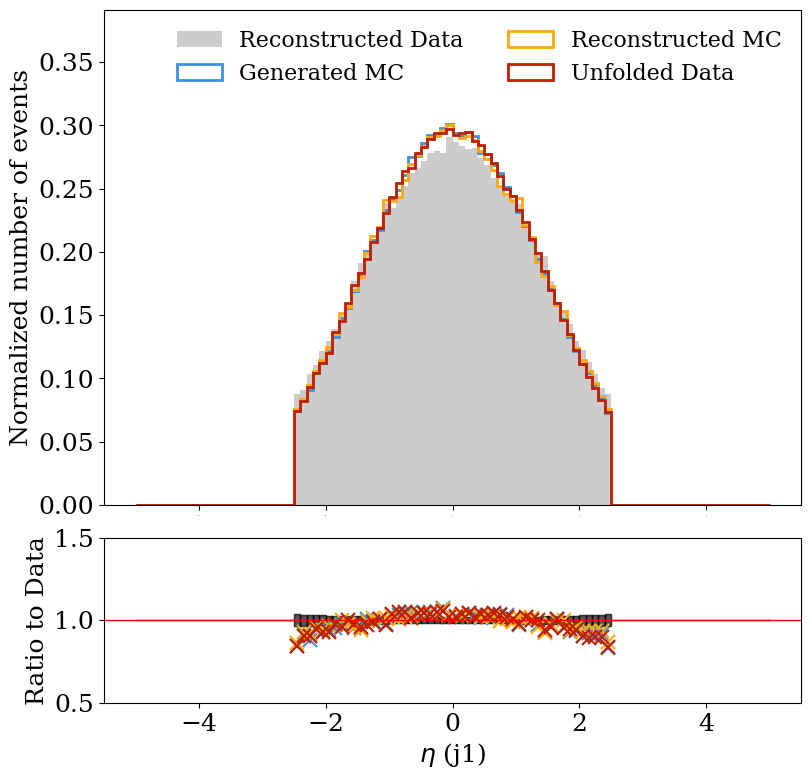

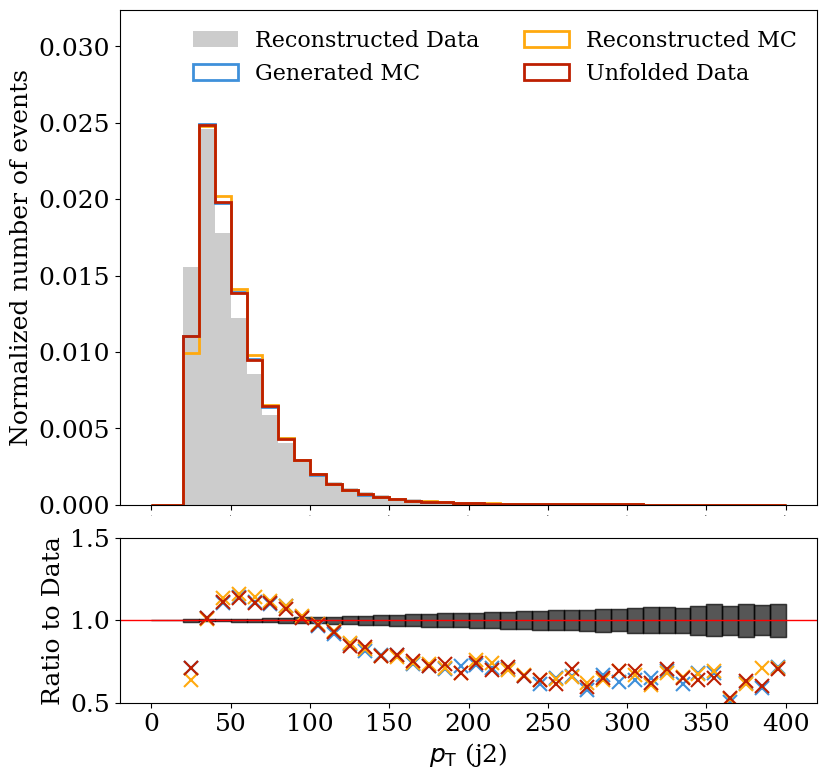

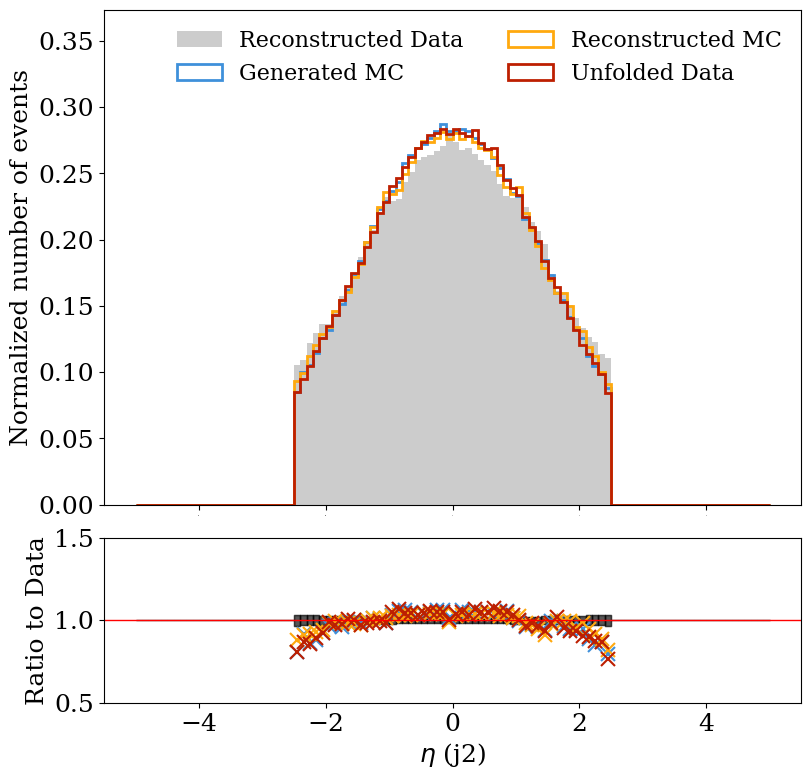

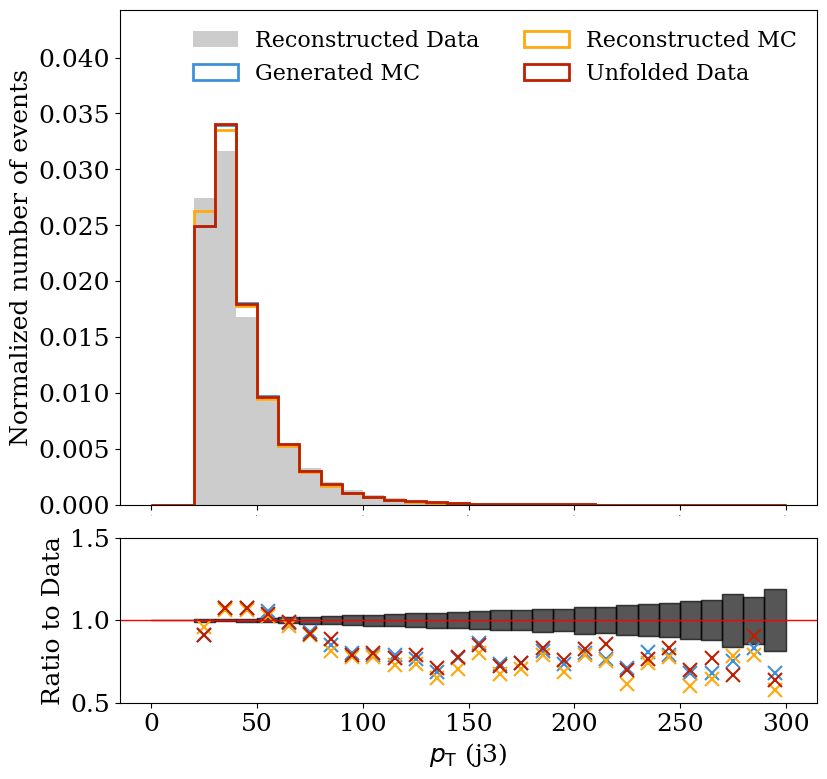

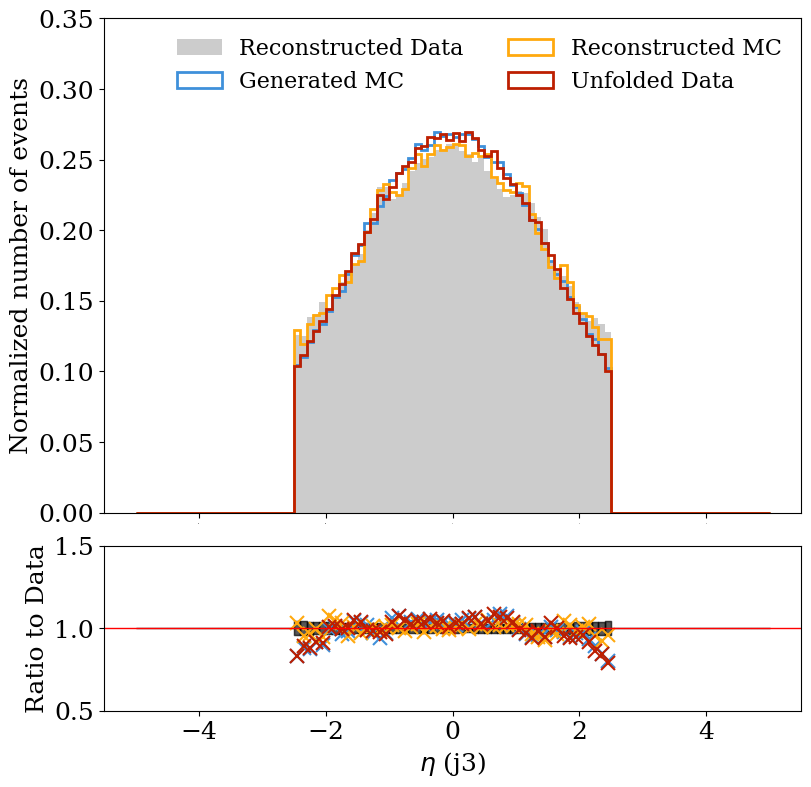

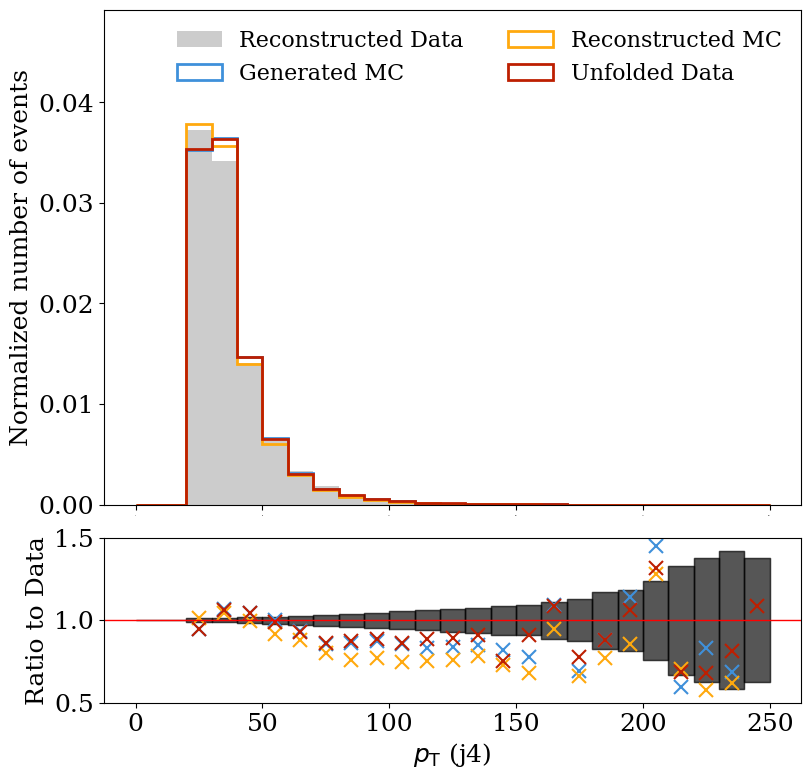

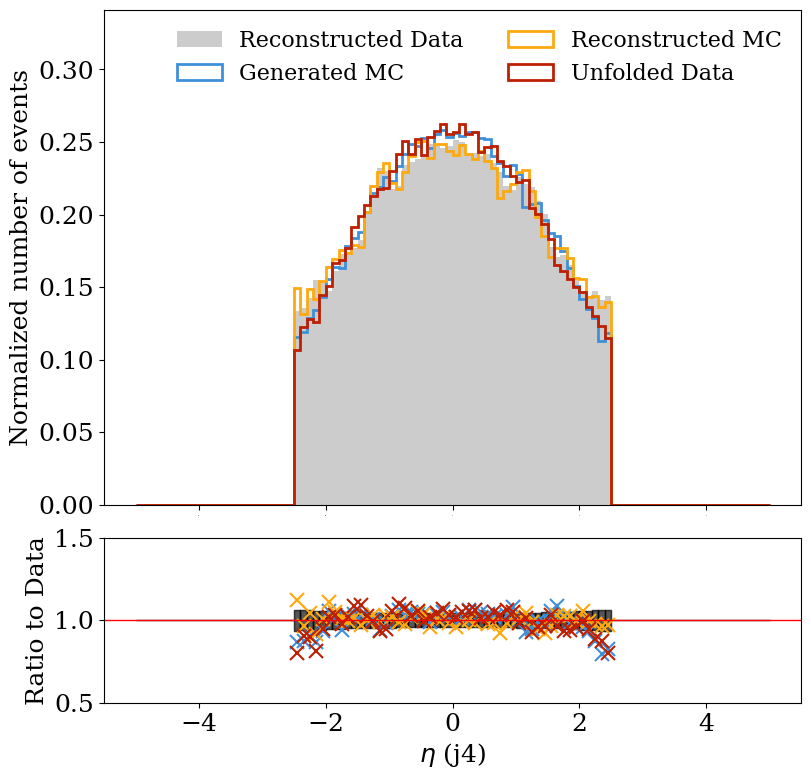

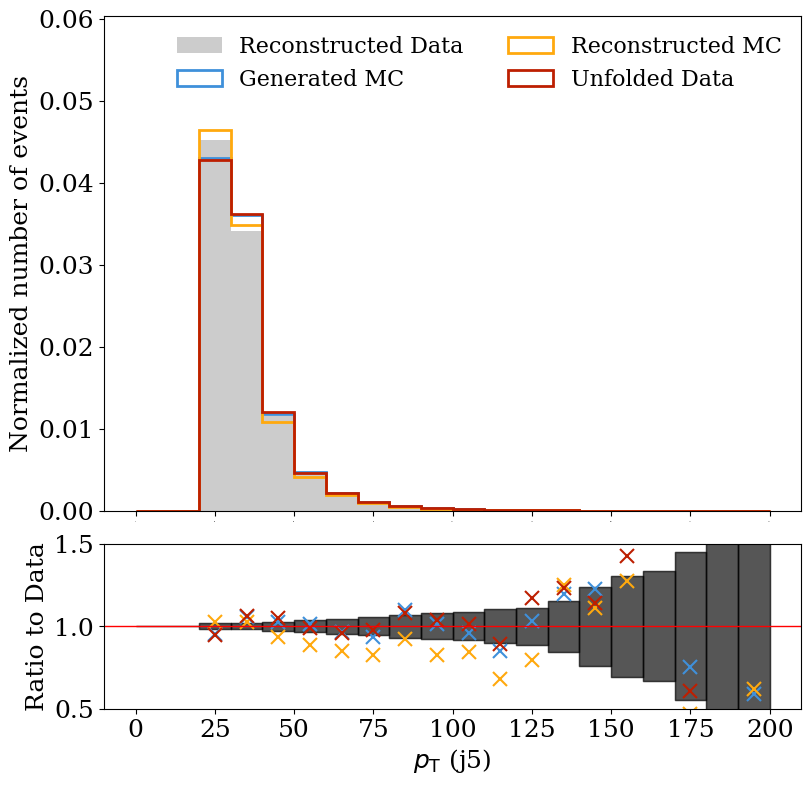

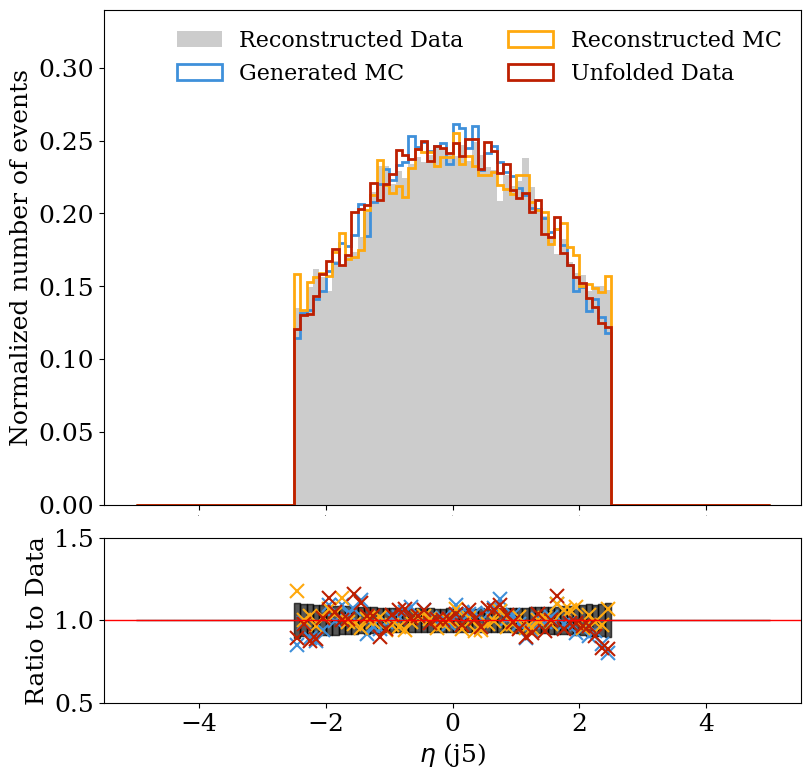

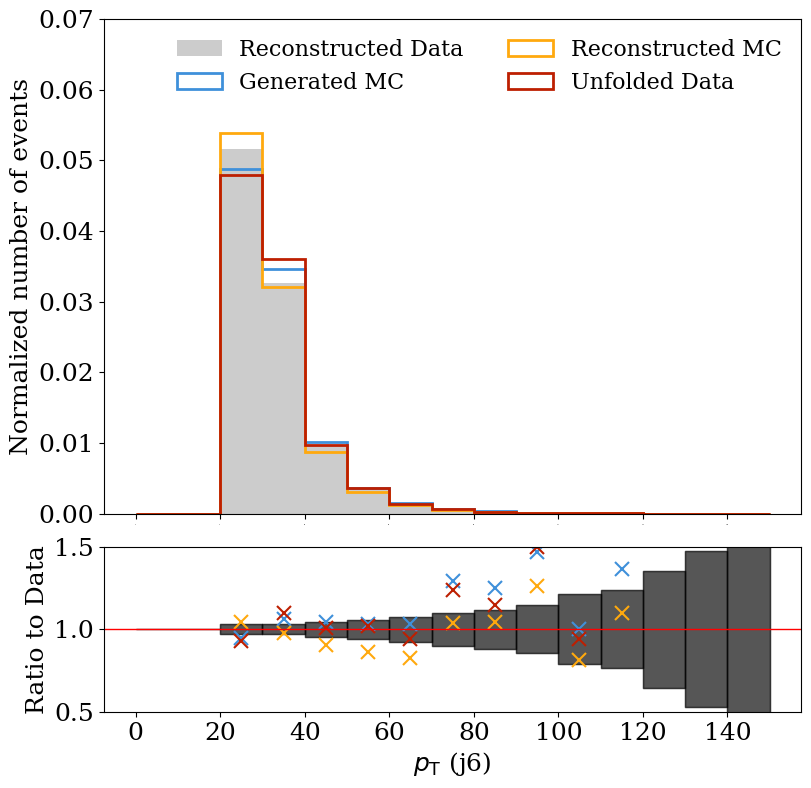

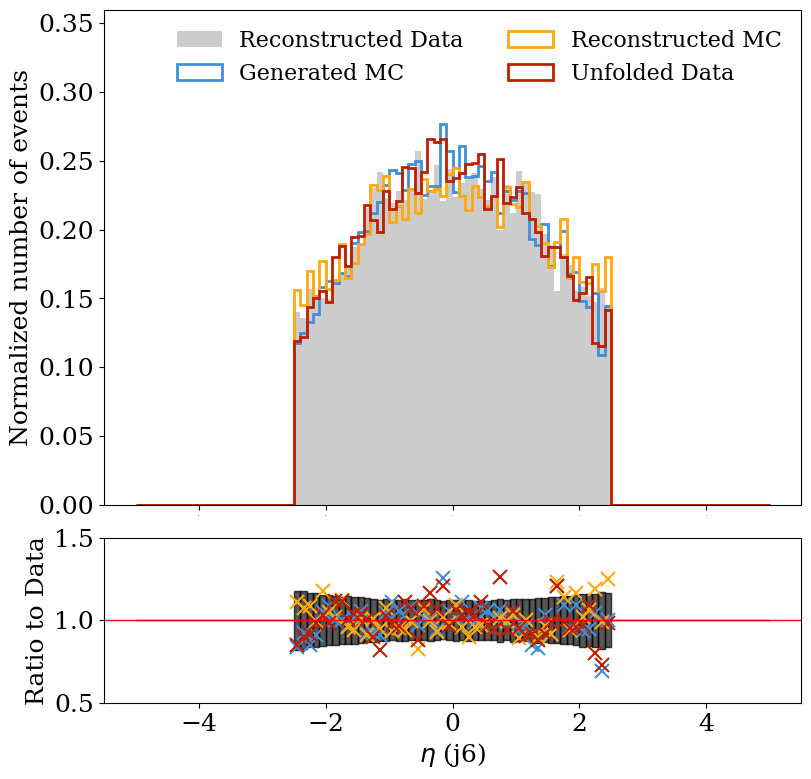

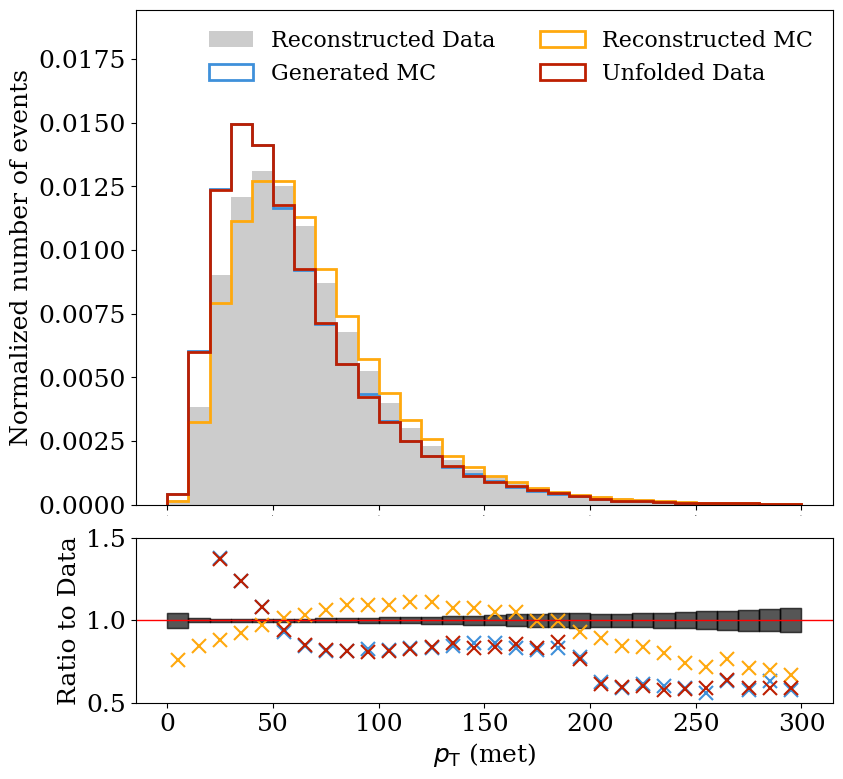

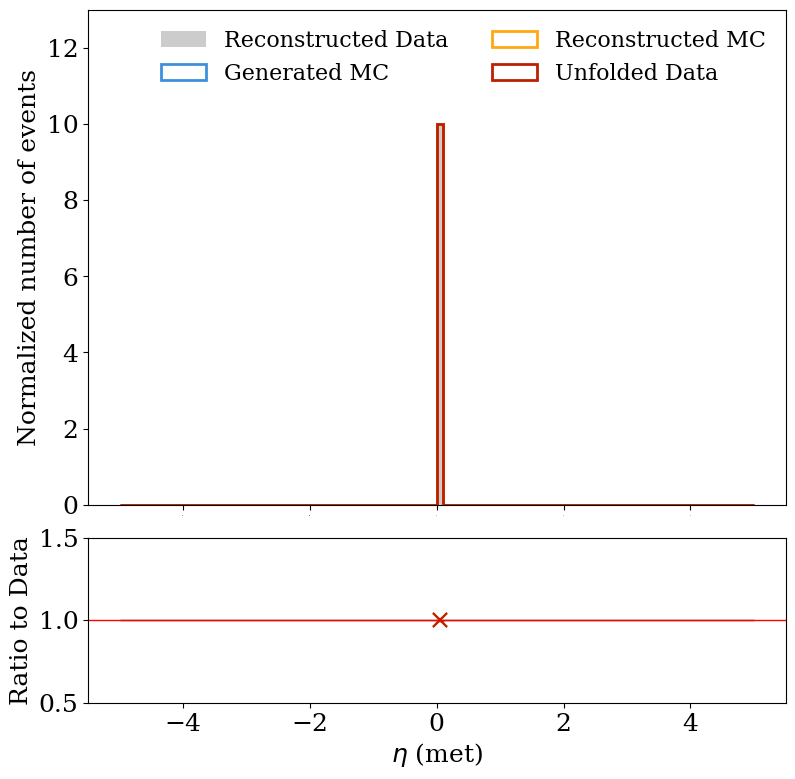

In [16]:
def compute_relative_bin_uncertainty(values, weights, binning):
    """
    Compute per-bin statistical uncertainties: sqrt(sum(w²)) / sum(w)
    
    Parameters:
        values: array of observable values per event (e.g., pt or eta)
        weights: array of weights per event (same shape as values)
        binning: array of bin edges
    
    Returns:
        relative_uncertainty: array of length (len(binning)-1)
    """
    # Histogram: sum of weights (Σw)
    sum_w, _ = np.histogram(values, bins=binning, weights=weights)
    
    # Histogram: sum of squared weights (Σw²)
    sum_w2, _ = np.histogram(values, bins=binning, weights=weights**2)
    
    # Compute relative uncertainty
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_uncertainty = np.sqrt(sum_w2) / sum_w
        rel_uncertainty[~np.isfinite(rel_uncertainty)] = 0  # Handle 0/0 and inf
    
    return rel_uncertainty

particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(0, 300, 31),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
default_binning = [
    None,  # placeholder for pt, unused
    np.linspace(-5, 5, 101),     # eta
]

labels = [
    r"$p_\mathrm{T}$",
    r"$\eta$",
]


for i, pname in enumerate(particles):
    for obs_index in range(2):  # 0: pT, 1: eta
        if obs_index == 0:
            bins = pt_binning[pname]
        else:
            bins = default_binning[obs_index]
        data_dict = {
            #'Truth Distribution': herwig_loader.gen[:, i, obs_index][herwig_loader.gen[:, i, 0]!=0],
            'Reconstructed Data': data_loader.reco[:, i, obs_index][data_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_loader.gen[:, i, obs_index][pythia_loader.gen[:, i, 0]!=0],
            'Reconstructed MC': pythia_loader.reco[:, i, obs_index][pythia_loader.reco[:, i, 0]!=0],
            'Unfolded Data': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0]!=0],
        }

        weight_dict = {
            #'Truth Distribution': herwig_loader.weight[herwig_loader.gen[:, i, 0]!=0],
            'Reconstructed Data': data_loader.weight[data_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_loader.weight[pythia_loader.gen[:, i, 0]!=0],
            'Reconstructed MC': pythia_loader.weight[pythia_loader.reco[:, i, 0]!=0],
            'Unfolded Data': unfolded_weights[pythia_truth_test[:, i, 0]!=0]*pythia_weights_test[pythia_truth_test[:, i, 0]!=0],
        }
        #ref_name = 'Generated MC'  # or 'Reconstructed MC', depending on your comparison
        #ref_vals = data_dict
        #ref_wgts = weight_dict[ref_name]
        relative_unc = compute_relative_bin_uncertainty(data_dict['Generated MC'], weight_dict['Generated MC'], bins)
        scaled_rel_unc = relative_unc * total_SF
        #print(scaled_rel_unc)
        fig, _ = HistRoutine(
            data_dict,
            f"{labels[obs_index]} ({pname})",
            reference_name='Reconstructed Data',
            weights=weight_dict,
            plot_ratio=True,
            binning=bins,
            uncertainty= scaled_rel_unc
        )